In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from copy import deepcopy # To copy objects

# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

import riskfolio as rf
import ta
import scipy
print(scipy.__version__)

from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

1.16.1


## PART I: PREPROCESSING


### 1.1 Gather data

In [2]:
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
tickers = ['TSLA', 'META', 'NVDA', 'JPM', 'JNJ' ]
n = len(tickers)
risk_free_rate = 0.02
cash = 10000000  # 10 million USD

start_date = "2023-01-01"
end_date = "2025-10-31"
split_date = "2024-12-31" 
split_validation_date = "2025-05-31"

# def get_data( tickers, start_date, end_date):
#     try:
#         print(f"Getting data for {n} tickers: {tickers}")
#         print(f"Total period: {start_date} to {end_date}")
#         data = yf.download(tickers, start=start_date, end=end_date)['Close']
#         if data.empty:
#             raise ValueError("No data fetched.")
        
#         print("Data loading completed.")
#         return data
#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None

# all_data = get_data(tickers, start_date, end_date)

In [3]:
all_data = pd.read_csv('stock_data1.csv', index_col=0, parse_dates=True)
# all_data.to_csv('stock_data1.csv'  )
all_data

,JNJ,JPM,META,NVDA,TSLA
Date,,,,,
2023-01-03,162.655899,125.492218,123.975723,14.301477,108.099998
2023-01-04,164.426788,126.662453,126.589607,14.735069,113.639999
2023-01-05,163.212708,126.634392,126.162247,14.251529,110.339996
2023-01-06,164.536285,129.057632,129.223389,14.844965,113.059998
2023-01-09,160.273407,128.524277,128.676727,15.613241,119.769997
...,...,...,...,...,...
2025-10-24,189.198730,300.440002,738.359985,186.259995,433.720001
2025-10-27,189.099365,304.149994,750.820007,191.490005,452.420013
2025-10-28,185.750626,305.359985,751.440002,201.029999,460.549988


In [4]:
all_data.index = all_data.index.tz_localize('America/New_York', ambiguous='infer')
print(f"Timezone after localization: {all_data.index.tz}")

train_data = all_data.loc[:split_date]
validation_data = all_data.loc[split_date:split_validation_date]
test_data = all_data.loc[split_validation_date:]

print(f"Train Set: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Validation Set:  {validation_data.index.min().date()} -> {validation_data.index.max().date()} ({len(validation_data)} days)")
print(f"Test Set:  {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")

Timezone after localization: America/New_York
Train Set: 2023-01-03 -> 2024-12-31 (502 days)
Validation Set:  2024-12-31 -> 2025-05-30 (103 days)
Test Set:  2025-06-02 -> 2025-10-30 (106 days)


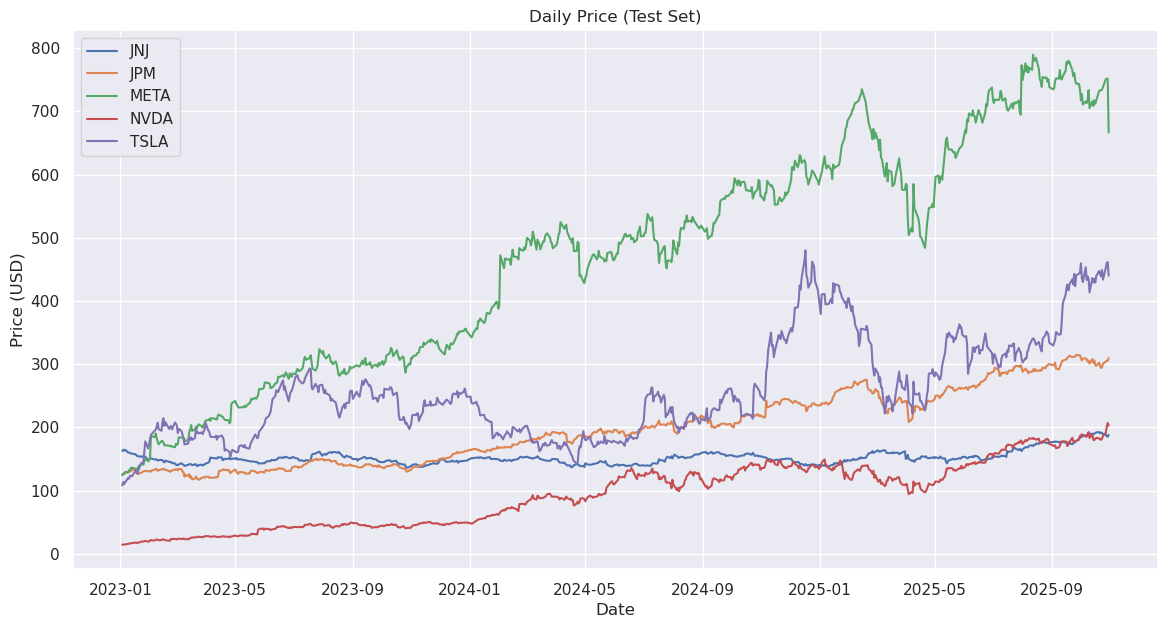

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(all_data.index, all_data, label=all_data.columns)
plt.title('Daily Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 1.2 Return and risk calculation

In [6]:
return_train = expected_returns.mean_historical_return(train_data, frequency=252)
cov_train = risk_models.sample_cov(train_data, frequency=252)

In [7]:
# Use SPY as an example
# spy = all_data[['SPY']].copy().dropna()

# # 1. Calculate Simple Return
# spy['Returns_Simple'] = spy['SPY'].pct_change()

# # 2. Calculate Log Return
# spy['Returns_Log'] = np.log(spy['SPY'] / spy['SPY'].shift(1))

# # Drop the first NA row (from .pct_change() and .shift())
# spy = spy.dropna()

# print(spy.head())

# # Price chart and histogram of SPY log returns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # Price plot
# spy['SPY'].plot(ax=ax1, title='SPY Price', color='#156ffb')
# ax1.set_ylabel('Price (USD)')
# ax1.grid(True)

# # Histogram of log returns
# sns.histplot(spy['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='#8fce00')
# ax2.set_title('Distribution of SPY Daily Log Returns')
# ax2.set_xlabel('Log Return')
# ax2.set_ylabel('Frequency')
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

### 1.3 Rolling statistic

SMA

In [8]:
# Calculate 50-day and 200-day SMA for SPY
# spy['SMA50'] = spy['SPY'].rolling(window=50).mean()
# spy['SMA200'] = spy['SPY'].rolling(window=200).mean()

# # Visualize SMA (only last 2 years for clarity)
# print("Visualizing SPY 50 and 200 SMA (Last 2 years):")
# spy.iloc[-500:][['SPY', 'SMA50', 'SMA200']].plot(
#     title='SPY 50-day vs 200-day SMA', 
#     figsize=(14, 7), 
#     color={'SPY': '#017cf3', 'SMA50': '#ffc340', 'SMA200': '#8fce00'}
# )
# plt.show()

Volatility

In [9]:
# Calculate 21-day rolling std dev of Log Returns
# (21 trading days ~ 1 month)
# Multiply by sqrt(252) (trading days in a year) to *annualize* it
# spy['Volatility'] = spy['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

# print("Visualizing SPY 21-day Rolling Volatility (Annualized):")
# spy['Volatility'].iloc[-500:].plot(title='SPY 21-day Rolling Volatility (Annualized)', figsize=(14, 6))
# plt.ylabel('Annualized Volatility')
# plt.show()

Rolling Correlation

In [10]:
# Get log returns for AAPL and SPY (the market)
# market_returns = np.log(all_data['SPY'] / all_data['SPY'].shift(1))
# stock_returns = np.log(all_data['AAPL'] / all_data['AAPL'].shift(1))

# # Calculate 60-day rolling correlation (~ 3 months)
# rolling_corr = stock_returns.rolling(window=60).corr(market_returns)
# rolling_corr = rolling_corr.dropna()

# print("Visualizing 60-day Rolling Correlation (AAPL vs SPY):")
# rolling_corr.iloc[-500:].plot(title='AAPL vs SPY 60-day Rolling Correlation', figsize=(14, 6))
# plt.ylabel('Correlation Coefficient')
# plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label=f'Average ({rolling_corr.mean():.2f})')
# plt.legend()
# plt.show()

- MFI _ Money flow index
- RSI
- MACD
- SMA
- ADX
- ROC

## PART II: COMPREHENSIVE PORTFOLIO OPTIMIZZATION STRATEGY - SUMMARY

### 2: PORTFOLIO OPTIMIZATION METHODS


#### 2.1 Dynamic Rebalancing with Rolling Windows

**Understanding Rolling Windows**

Rolling windows is a fundamental concept in quantitative finance that enables dynamic analysis of time-series data by creating a "moving window" of fixed size that slides through the dataset. Instead of using all historical data at once, rolling windows analyze only the most recent N periods, providing more adaptive and responsive portfolio optimization.

**Key Concept**: A rolling window of **63 days** means we always look at the last 63 trading days (~3 months) to make optimization decisions. As new data arrives, the oldest data point is dropped, maintaining a constant window size while keeping the analysis current and relevant to recent market conditions.

**Mathematical Foundation**

For a rolling window of size W at time t:
- **Historical Returns Window**: $R_{t-W+1}, R_{t-W+2}, ..., R_t$
- **Expected Return Estimation**: $\mu_t = \frac{1}{W} \sum_{i=t-W+1}^{t} R_i \times 252$
- **Covariance Matrix Estimation**: $\Sigma_t = \frac{252}{W-1} \sum_{i=t-W+1}^{t} (R_i - \bar{R})(R_i - \bar{R})^T$

**Dynamic Rebalancing Process**:
1. **Rolling Optimization**: Every **21 days** (monthly), recalculate optimal weights using the latest 63-day window
2. **Adaptive Learning**: Portfolio learns from recent market behavior rather than relying on outdated historical patterns
3. **Risk Management**: Position constraints (5%-40% per asset) prevent over-concentration
4. **Transaction Cost Control**: Rebalancing frequency balances adaptability with trading costs

**Practical Benefits**:
- **Market Adaptation**: Responds to changing market conditions and correlations
- **Reduced Model Risk**: Less dependent on long-term historical assumptions
- **Volatility Clustering**: Captures periods of high/low volatility more effectively
- **Regime Detection**: Automatically adjusts to different market environments (bull/bear markets)

**Example Implementation**: 
- Window Size: 63 trading days (≈3 months of market data)
- Rebalancing: Every 21 days (≈monthly frequency)
- This creates ~12 rebalancing events per year with fresh market insights

**Risk Considerations**:
- **Lookback Sensitivity**: Shorter windows = more reactive but potentially noisier
- **Rebalancing Costs**: More frequent rebalancing increases transaction costs
- **Market Microstructure**: Rolling windows help avoid overfitting to specific market periods


In [11]:
# Dynamic Portfolio Optimization with Rolling Windows
def dynamic_portfolio_optimization(data, lookback_window=63, rebalance_freq=21):

    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize portfolio weights history
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data for optimization
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize portfolio (Max Sharpe with constraints)
            try:
                current_weights = optimize_max_sharpe_constrained(mu, cov, risk_free_rate)
            except:
                # Fallback to equal weights if optimization fails
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()


def optimize_max_sharpe_constrained(mu, cov, rf_rate=0.02, max_weight=0.4, min_weight=0.05):
    """
    Optimize portfolio for maximum Sharpe ratio with weight constraints
    """
    n_assets = len(mu)
    
    def objective(weights):
        portfolio_return = np.dot(weights, mu)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return -(portfolio_return - rf_rate) / portfolio_vol  # Negative for minimization
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Initial guess
    x0 = np.array([1/n_assets] * n_assets)
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        return np.array([1/n_assets] * n_assets)

print("Dynamic Portfolio Optimization functions defined successfully.")

# Apply dynamic optimization to our data
print("\n--- Applying Dynamic Portfolio Optimization ---")
dynamic_weights, dynamic_returns = dynamic_portfolio_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Dynamic optimization completed for {len(dynamic_returns)} trading days")
print("\nSample of dynamic weights (last 10 days):")
print(dynamic_weights.tail(10).round(3))

Dynamic Portfolio Optimization functions defined successfully.

--- Applying Dynamic Portfolio Optimization ---
Dynamic optimization completed for 438 trading days

Sample of dynamic weights (last 10 days):
                            JNJ       JPM      META      NVDA     TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-18 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-19 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-20 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-23 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-24 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-26 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-27 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-30 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-31 0

#### 2.2 Kelly Criterion Dynamic Portfolio Optimization

**Understanding Kelly Criterion**

The Kelly Criterion is a mathematical formula used to determine the optimal position size for investments with known probabilities and payoffs. Originally developed for gambling, it has been adapted for portfolio optimization to maximize long-term growth rate while managing risk through position sizing.

**Key Concept**: Unlike traditional portfolio optimization that focuses on risk-adjusted returns, Kelly Criterion determines what fraction of capital should be allocated to each investment to maximize the expected logarithm of wealth over time.

**Mathematical Foundation**

The Kelly Criterion seeks to find the optimal fraction of capital (f) to allocate to each asset:

**Kelly Formula:**
$$
f = \frac{bp - q}{b} = \frac{p \cdot E[R] - (1-p) \cdot E[L]}{E[R]}
$$

Where:
- $f$ = Fraction of capital to allocate to the asset
- $b$ = Odds received (expected return when winning)
- $p$ = Probability of a positive return
- $q$ = Probability of a negative return (1-p)
- $E[R]$ = Expected return when positive
- $E[L]$ = Expected loss when negative

**Portfolio Kelly Optimization:**
$$
f_i = \max\left(0, \frac{\text{Sharpe}_i \cdot p_i - (1-p_i)}{\text{Sharpe}_i}\right)
$$

**Practical Example**: 
- Asset A: 60% win probability, 10% expected return → Kelly suggests ~20% allocation
- Asset B: 70% win probability, 8% expected return → Kelly suggests ~25% allocation
- The method naturally reduces allocation to riskier assets

**Implementation Benefits:**
- **Growth Optimization**: Maximizes long-term compound growth rate
- **Risk Control**: Prevents over-leveraging through mathematical constraints
- **Adaptive Sizing**: Automatically adjusts position sizes based on win probability
- **Bankruptcy Protection**: Built-in safeguards against total capital loss

**Conservative Implementation**: Our implementation uses fractional Kelly (25% of full Kelly) to reduce volatility while maintaining growth advantages.

In [12]:
# Kelly Criterion Portfolio Optimization
def kelly_criterion_optimization(mu, cov, confidence_level=0.6):
    n_assets = len(mu)
    kelly_weights = np.zeros(n_assets)
    
    # Calculate individual asset Kelly fractions
    volatilities = np.sqrt(np.diag(cov))
    
    for i in range(n_assets):
        if volatilities[i] > 0 and mu[i] > 0:
            # Estimate win probability based on Sharpe ratio
            sharpe = mu[i] / volatilities[i]
            win_prob = min(0.5 + sharpe * 0.1, 0.85)  # Cap at 85%
            
            # Kelly fraction calculation
            odds_ratio = mu[i] / volatilities[i]  # Return to risk ratio
            kelly_fraction = (odds_ratio * win_prob - (1 - win_prob)) / odds_ratio
            
            # Apply conservative scaling (fractional Kelly)
            kelly_weights[i] = max(0, kelly_fraction * 0.25)  # Use 25% of full Kelly
    
    # Normalize weights to sum to 1
    if kelly_weights.sum() > 0:
        kelly_weights = kelly_weights / kelly_weights.sum()
    else:
        kelly_weights = np.array([1/n_assets] * n_assets)  # Equal weights fallback
    
    return kelly_weights

def dynamic_kelly_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Kelly Criterion optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize using Kelly Criterion
            try:
                current_weights = kelly_criterion_optimization(mu, cov)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Kelly Criterion optimization functions defined successfully.")

# Apply Kelly optimization to our data
print("\n--- Applying Kelly Criterion Dynamic Portfolio Optimization ---")
kelly_weights, kelly_returns = dynamic_kelly_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Kelly optimization completed for {len(kelly_returns)} trading days")
print("\nSample of Kelly weights (last 10 days):")
print(kelly_weights.tail(10).round(3))

Kelly Criterion optimization functions defined successfully.

--- Applying Kelly Criterion Dynamic Portfolio Optimization ---
Kelly optimization completed for 438 trading days

Sample of Kelly weights (last 10 days):
                           JNJ       JPM      META      NVDA      TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-18 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-19 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-20 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-23 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-24 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-26 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-27 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-30 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
20

#### 2.3 Risk Parity Dynamic Portfolio Optimization

**Understanding Risk Parity**

Risk Parity is an advanced portfolio construction method that aims to achieve equal risk contribution from each asset, rather than equal dollar allocation. Unlike traditional equal-weight portfolios where each stock gets the same percentage allocation (e.g., 20% each for 5 stocks), Risk Parity ensures each asset contributes the same amount of risk to the overall portfolio.

**Key Concept**: In a traditional 20% equal-weight portfolio, if one stock is much more volatile than others, it will dominate the portfolio's risk despite having the same allocation. Risk Parity solves this by giving smaller allocations to riskier assets and larger allocations to safer assets.

**Mathematical Foundation**

The Risk Parity optimization seeks to find portfolio weights where each asset's **Risk Contribution (RC)** is equal:

**Risk Contribution Formula:**
$$
RC_i = w_i \times \frac{\partial \sigma_p}{\partial w_i} = w_i \times \frac{(\mathbf{\Sigma} \mathbf{w})_i}{\sigma_p}
$$

Where:
- $RC_i$ = Risk contribution of asset i
- $w_i$ = Weight of asset i in the portfolio  
- $σ_p$ = Portfolio volatility = √(w^T × Σ × w)
- $Σ$ = Covariance matrix of asset returns
- $(Σw)_i$ = i-th element of the matrix multiplication Σ×w

**Target Condition:**
$$
RC_1 = RC_2 = RC_3 = ... = RC_n = σ_p² / n
$$

**Practical Example**: 
- Traditional Equal Weight: Stock A (20%), Stock B (20%) - but if Stock A is 2x more volatile, it contributes ~67% of portfolio risk
- Risk Parity: Stock A (12%), Stock B (28%) - now both contribute 50% of portfolio risk each

**Implementation Benefits:**
- **Better Diversification**: Prevents volatile assets from dominating portfolio risk
- **Stability**: More consistent risk exposure across different market conditions  
- **Downside Protection**: Reduces concentration in high-risk periods
- **All-Weather**: Performs well across various economic environments

In [13]:
# Risk Parity Portfolio Optimization
def risk_parity_optimization(cov, max_iterations=1000, tolerance=1e-8):
    n_assets = len(cov)
    
    # Start with equal weights
    weights = np.array([1/n_assets] * n_assets)
    
    # Iterative algorithm to find risk parity weights
    for iteration in range(max_iterations):
        # Calculate risk contributions
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        marginal_risk = np.dot(cov, weights) / portfolio_vol
        risk_contributions = weights * marginal_risk
        
        # Target risk contribution (equal for all assets)
        target_risk = portfolio_vol ** 2 / n_assets
        
        # Update weights based on risk contribution differences
        risk_diff = risk_contributions - target_risk
        
        # Convergence check
        if np.max(np.abs(risk_diff)) < tolerance:
            break
        
        # Update weights (move away from over-contributing assets)
        adjustment_factor = 0.05  # Learning rate
        weight_updates = -adjustment_factor * risk_diff / marginal_risk
        weights = weights + weight_updates
        
        # Ensure non-negative weights and renormalize
        weights = np.maximum(weights, 1e-8)
        weights = weights / weights.sum()
    
    return weights

def dynamic_risk_parity_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Risk Parity optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate covariance matrix
            cov = hist_returns.cov() * 252
            
            # Optimize using Risk Parity
            try:
                # Check if covariance matrix is valid
                eigenvals = np.linalg.eigvals(cov)
                if np.all(eigenvals > 0):
                    current_weights = risk_parity_optimization(cov)
                else:
                    # Fallback: use correlation matrix with equal volatilities
                    corr = hist_returns.corr()
                    vol_avg = hist_returns.std().mean() * np.sqrt(252)
                    cov_regularized = corr * (vol_avg ** 2)
                    current_weights = risk_parity_optimization(cov_regularized)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Risk Parity optimization functions defined successfully.")

# Apply Risk Parity optimization to our data
print("\n--- Applying Risk Parity Dynamic Portfolio Optimization ---")
rp_weights, rp_returns = dynamic_risk_parity_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Risk Parity optimization completed for {len(rp_returns)} trading days")
print("\nSample of Risk Parity weights (last 10 days):")
print(rp_weights.tail(10).round(3))

Risk Parity optimization functions defined successfully.

--- Applying Risk Parity Dynamic Portfolio Optimization ---
Risk Parity optimization completed for 438 trading days

Sample of Risk Parity weights (last 10 days):
                           JNJ       JPM      META      NVDA      TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-18 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-19 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-20 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-23 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-24 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-26 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-27 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-30 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.11789

#### 2.4 Optimize $k$-of-$n$ assets (Max Sharpe)
This methods find the best combinations (in this case 15 tickers combination) to find the number of $k$ tickers that give the best Sharpe Ratio.

In [14]:
print(f"--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---")
train_returns = train_data.pct_change().dropna()

# 1. Global tracking variables
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
all_results_sharpe = [] 

# 2. Calculate base metrics (from mu_train, S_train already calculated in 2.2)
individual_vol_series_train = pd.Series(np.sqrt(np.diag(cov_train)), index=tickers)
individual_sharpes_train = (return_train - risk_free_rate) / individual_vol_series_train
individual_vol_train = individual_vol_series_train.to_dict()

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            # 5. Optimize for this combination
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict
            
            all_results_sharpe.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================")
print(f"Highest Global Sharpe: {global_best_sharpe_k:.4f} (with k={len(global_best_weights_k_sharpe)}) ")
print("Static Weights found (k-MaxSharpe):")
print(pd.Series(global_best_weights_k_sharpe))

# 8. Print all results dataframe
all_results_sharpe_df = pd.DataFrame(all_results_sharpe).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Sharpe) ---")
print(all_results_sharpe_df[['k', 'Combination', 'Sharpe', 'Volatility']].head(15))

--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---

================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================
Highest Global Sharpe: 5.8135 (with k=1) 
Static Weights found (k-MaxSharpe):
TSLA    1.0
dtype: float64

--- Top 15 Combinations (Ranked by Sharpe) ---
    k                             Combination    Sharpe  Volatility
0   1                               ('TSLA',)  5.813462    0.158333
1   1                               ('NVDA',)  5.406641    0.381860
2   1                               ('META',)  5.236791    0.221655
3   5  ('TSLA', 'META', 'NVDA', 'JPM', 'JNJ')  4.452744    0.299017
4   4          ('META', 'NVDA', 'JPM', 'JNJ')  4.452744    0.299017
5   4         ('TSLA', 'META', 'NVDA', 'JPM')  4.452593    0.303486
6   3                 ('META', 'NVDA', 'JPM')  4.452593    0.303486
7   4         ('TSLA', 'META', 'NVDA', 'JNJ')  4.379997    0.338436
8   3                 ('META', 'NVDA', 'JNJ')  4.378018    0.341102
9   3                ('TSLA', 'MET

#### 2.5 Optimize $k$-of-$n$ assets (Min Volatility)
This methods find the best combinations (in this case 15 tickers combination) to find the number of $k$ tickers that give the lowest Volatility.

In [15]:
print(f"--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---")

# 1. Global tracking variables
global_best_vol_k = np.inf
global_best_weights_k_vol = None
all_results_vol = [] 

# (No need to recalculate individual_vol_train, use from 2.6)

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.min_volatility() # <-- CHANGE OBJECTIVE
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results (CHANGE OBJECTIVE)
            if vol < global_best_vol_k:
                global_best_vol_k = vol
                global_best_weights_k_vol = weights_dict
            
            all_results_vol.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================")
print(f"Lowest Global Volatility: {global_best_vol_k:.4f} (with k={len(global_best_weights_k_vol)}) ")
print("Static Weights found (k-MinVol):")
print(pd.Series(global_best_weights_k_vol))

# 8. Print all results dataframe
all_results_vol_df = pd.DataFrame(all_results_vol).sort_values(by='Volatility', ascending=True).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Volatility) ---")
print(all_results_vol_df[['k', 'Combination', 'Volatility', 'Sharpe']].head())

--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---

================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================
Lowest Global Volatility: 0.1281 (with k=5) 
Static Weights found (k-MinVol):
TSLA    0.00778
META    0.06795
NVDA    0.07336
JPM     0.19173
JNJ     0.65918
dtype: float64

--- Top 15 Combinations (Ranked by Volatility) ---
   k                             Combination  Volatility    Sharpe
0  5  ('TSLA', 'META', 'NVDA', 'JPM', 'JNJ')    0.128132  1.906395
1  4          ('META', 'NVDA', 'JPM', 'JNJ')    0.128200  1.909063
2  4          ('TSLA', 'NVDA', 'JPM', 'JNJ')    0.130340  1.665959
3  3                  ('NVDA', 'JPM', 'JNJ')    0.130583  1.658982
4  4          ('TSLA', 'META', 'JPM', 'JNJ')    0.132365  1.218513


#### 2.6 Strategy Comparison on Train test

=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===
=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 438

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2024-12-17 00:00:00-05:00             -0.0012         0.0031              -0.0026
2024-12-18 00:00:00-05:00             -0.0337        -0.0407              -0.0355
2024-12-19 00:00:00-05:00              0.0030         0.0028               0.0043
2024-12-20 00:00:00-05:00              0.0011        -0.0014               0.0023
2024-12-23 00:00:00-05:00              0.0240         0.0241               0.0205
2024-12-24 00:00:00-05:00          

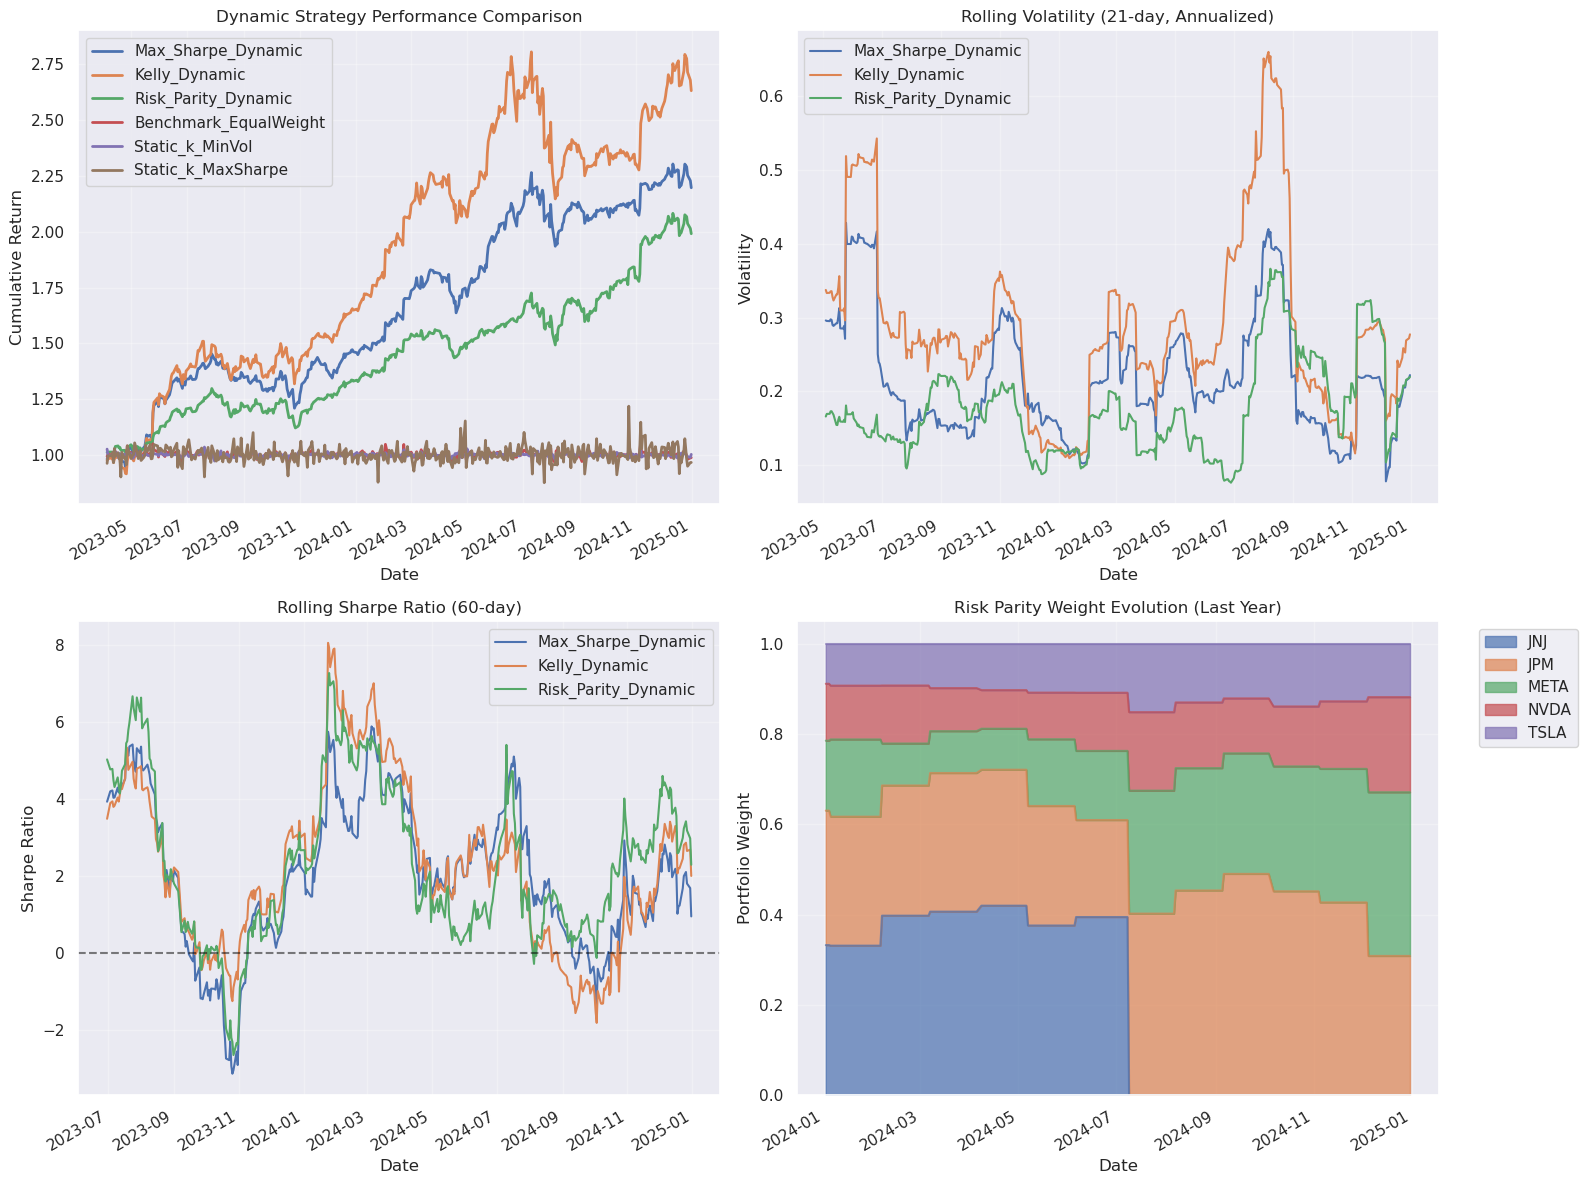


=== DYNAMIC STRATEGY PERFORMANCE METRICS ===

Performance Metrics Summary:
                     Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio  Sortino Ratio  Skewness  Kurtosis  VaR (95%)  CVaR (95%)
Max_Sharpe_Dynamic          0.6153             0.2322        2.5637       -0.1671        3.6825         4.0490    0.7888    6.4342    -0.0188     -0.0301
Kelly_Dynamic               0.8301             0.3105        2.6086       -0.2346        3.5381         3.8117    0.4714    6.3759    -0.0264     -0.0431
Risk_Parity_Dynamic         0.5127             0.1882        2.6173       -0.1359        3.7732         3.8094    0.2408    4.3770    -0.0175     -0.0256

Strategy Rankings (by Sharpe Ratio):
  1. Risk_Parity_Dynamic      :  2.6173
  2. Kelly_Dynamic            :  2.6086
  3. Max_Sharpe_Dynamic       :  2.5637

Key Insights:
  • Kelly Criterion: Optimized for long-term growth rate
  • Risk Parity: Equal risk contribution from all assets
  • Max Sharpe: Tradi

In [16]:
# Comprehensive Dynamic Strategy Comparison
equal_weights = {ticker: (1/n) for ticker in tickers}

def comprehensive_dynamic_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Compare multiple dynamic optimization methods
    """
    print("=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===")
    
    # Run all optimization methods
    methods = {}
    
    # 1. Maximum Sharpe (existing)
    print("Running Max Sharpe optimization...")
    methods['Max_Sharpe_Dynamic'] = dynamic_portfolio_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 2. Kelly Criterion
    print("Running Kelly Criterion optimization...")
    methods['Kelly_Dynamic'] = dynamic_kelly_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 3. Risk Parity
    print("Running Risk Parity optimization...")
    methods['Risk_Parity_Dynamic'] = dynamic_risk_parity_optimization(
        data, lookback_window, rebalance_freq
    )
    
    return methods

# Implementation
print("=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===")

# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    train_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1 + (train_returns * pd.Series(equal_weights)).sum(axis=1)
cumulative_performance['Static_k_MinVol'] = 1 + (train_returns[global_best_weights_k_vol.keys()] * pd.Series(global_best_weights_k_vol)).sum(axis=1)
cumulative_performance['Static_k_MaxSharpe'] = 1 + (train_returns[global_best_weights_k_sharpe.keys()] * pd.Series(global_best_weights_k_sharpe)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility (21-day, Annualized)')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(60)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio (60-day)')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='#000000', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution (Last Year)')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics calculation function
def calculate_comprehensive_metrics(returns_series, rf_rate=0.02):
    """Calculate comprehensive performance metrics"""
    if returns_series.empty or returns_series.std() == 0:
        return pd.Series({
            "Annual Return": 0, "Annual Volatility": 0, "Sharpe Ratio": 0,
            "Max Drawdown": 0, "Calmar Ratio": 0, "Sortino Ratio": 0,
            "Skewness": 0, "Kurtosis": 0, "VaR (95%)": 0, "CVaR (95%)": 0
        })
    
    # Basic metrics
    annual_return = (1 + returns_series.mean()) ** 252 - 1
    annual_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - rf_rate) / annual_volatility
    
    # Drawdown metrics
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Downside risk metrics
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = (annual_return - rf_rate) / downside_deviation if downside_deviation != 0 else 0
    
    # Distribution metrics
    skewness = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # Risk metrics
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    return pd.Series({
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95
    })

# Performance metrics comparison
print("\n=== DYNAMIC STRATEGY PERFORMANCE METRICS ===")
dynamic_metrics = {}
for strategy in dynamic_returns_df.columns:
    dynamic_metrics[strategy] = calculate_comprehensive_metrics(dynamic_returns_df[strategy])

dynamic_metrics_df = pd.DataFrame(dynamic_metrics).T
print("\nPerformance Metrics Summary:")
print(dynamic_metrics_df.round(4).to_string())

# Rank by Sharpe ratio
print(f"\nStrategy Rankings (by Sharpe Ratio):")
sharpe_ranking = dynamic_metrics_df['Sharpe Ratio'].sort_values(ascending=False)
for i, (strategy, sharpe) in enumerate(sharpe_ranking.items(), 1):
    print(f"  {i}. {strategy:25}: {sharpe:7.4f}")

print(f"\nKey Insights:")
print(f"  • Kelly Criterion: Optimized for long-term growth rate")
print(f"  • Risk Parity: Equal risk contribution from all assets")
print(f"  • Max Sharpe: Traditional risk-adjusted return optimization")
print(f"  • All methods use same rolling window framework for fair comparison")

#### 2.7 Compare the trading result tested on test section (Back test)
Metrics Analysis & Conclusion

=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 39

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2025-05-16 00:00:00-04:00              0.0071         0.0063               0.0074
2025-05-19 00:00:00-04:00              0.0014        -0.0047               0.0007
2025-05-20 00:00:00-04:00             -0.0001         0.0004               0.0034
2025-05-21 00:00:00-04:00             -0.0121        -0.0138              -0.0089
2025-05-22 00:00:00-04:00              0.0025         0.0047               0.0003
2025-05-23 00:00:00-04:00             -0.0048        -0.0058              -0.0023
202

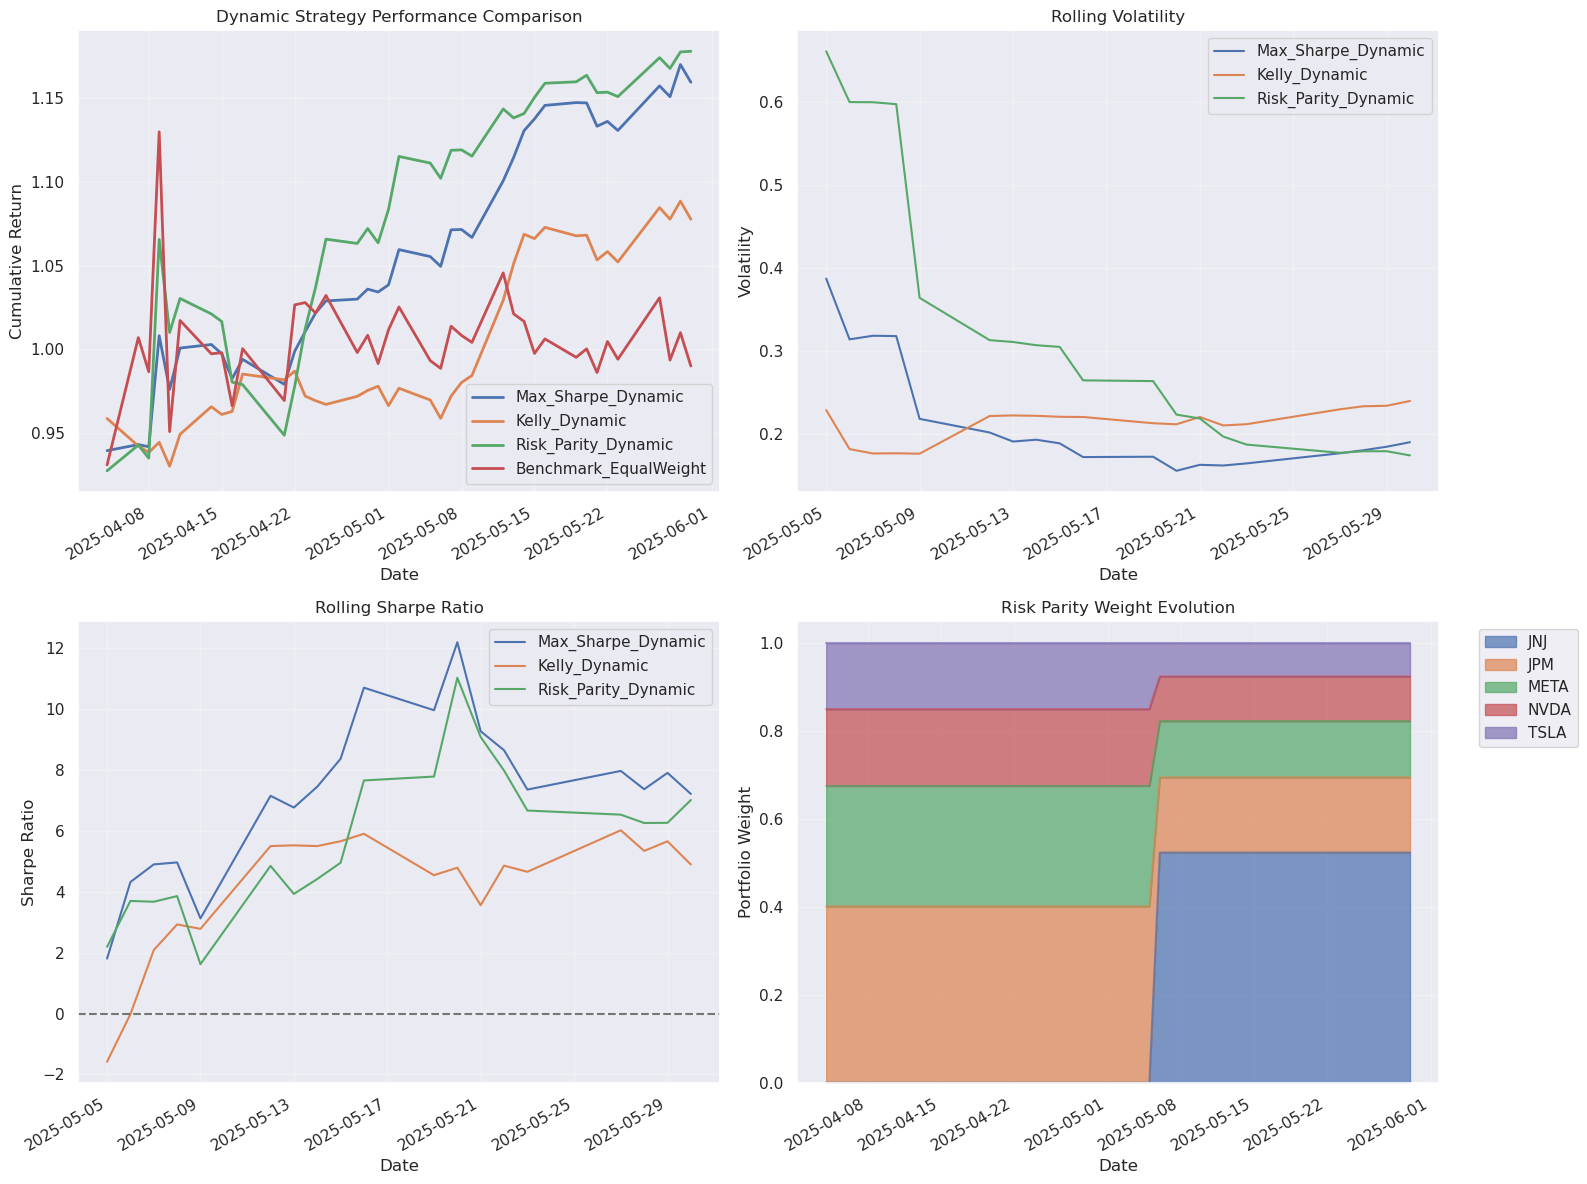

In [17]:
validation_returns = validation_data.pct_change().dropna()
# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    validation_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1+ (validation_returns * pd.Series(equal_weights)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(21)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='#000000', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PORTFOLIO OPTIMIZATION MODEL RANKING
                     Final_Rank  Sharpe_Ratio  Max_Drawdown  Calmar_Ratio  Volatility  Annual_Return
Risk_Parity_Dynamic           1        2.6173       -0.1359        3.7732      0.1882         0.5127
Kelly_Dynamic                 2        2.6086       -0.2346        3.5381      0.3105         0.8301
Max_Sharpe_Dynamic            3        2.5637       -0.1671        3.6825      0.2322         0.6153

BEST MODEL: Risk_Parity_Dynamic
Sharpe Ratio: 2.6173
Max Drawdown: -0.1359
Calmar Ratio: 3.7732
Volatility: 0.1882
Annual Return: 0.5127


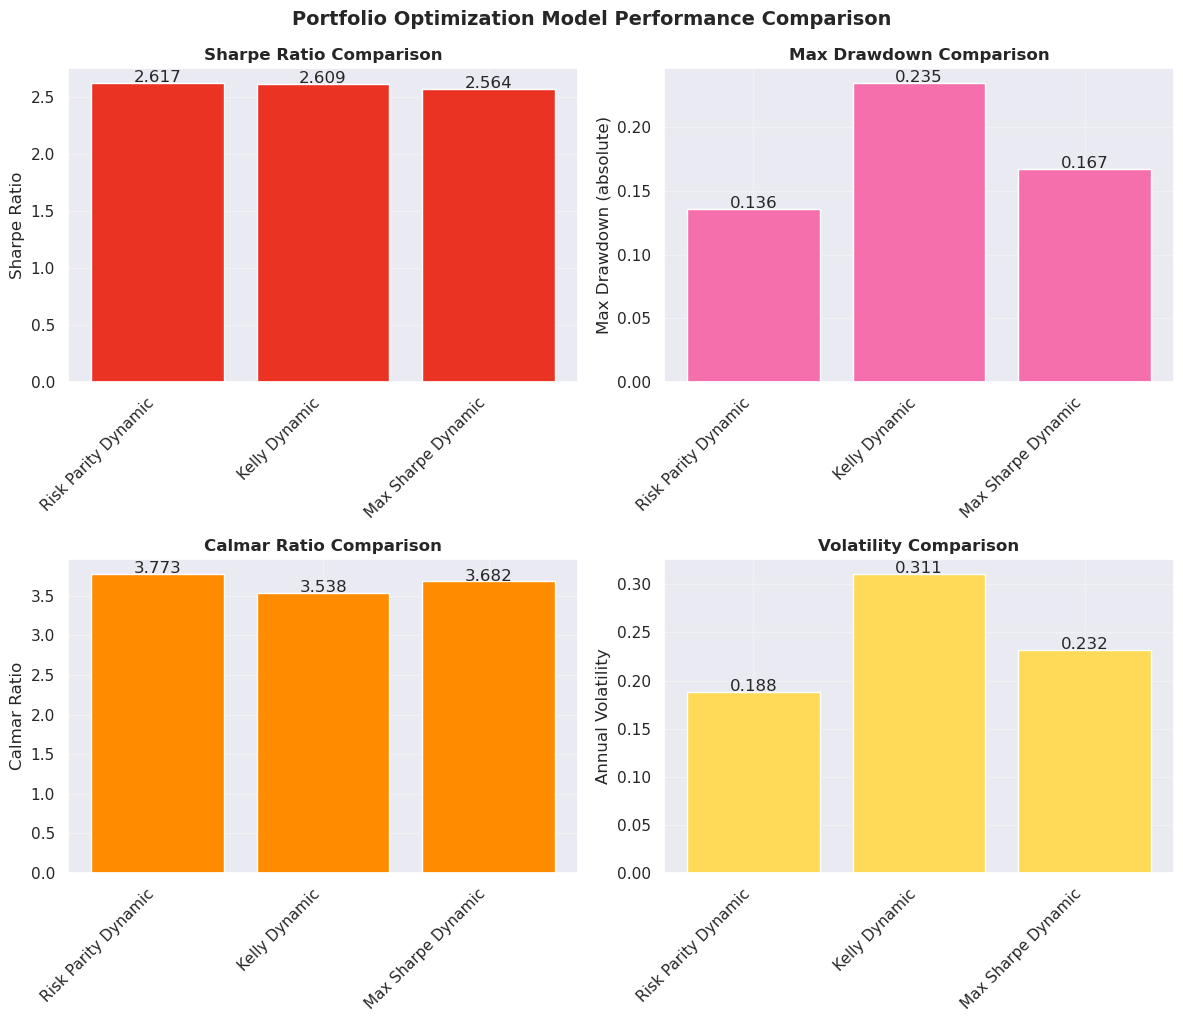


MODEL PERFORMANCE SUMMARY:
Model                Rank   Sharpe   Drawdown   Calmar  
------------------------------------------------------------
Risk Parity Dynamic  #1      2.617    -0.136     3.773   
Kelly Dynamic        #2      2.609    -0.235     3.538   
Max Sharpe Dynamic   #3      2.564    -0.167     3.682   


In [18]:
def calculate_best_portfolio_model(metrics_df, weights=None):
    if weights is None:
        weights = {
            'sharpe_ratio': 0.40,
            'max_drawdown': 0.30,
            'calmar_ratio': 0.20,
            'volatility': 0.10
        }
    
    # Create a copy to avoid modifying original
    df = metrics_df.copy()
    
    # Initialize scoring DataFrame
    scoring_df = pd.DataFrame(index=df.index)
    
    # 1. Sharpe Ratio Scoring (Higher is better: 1st=3pts, 2nd=2pts, 3rd=1pt)
    sharpe_ranks = df['Sharpe Ratio'].rank(ascending=False)
    scoring_df['Sharpe_Score'] = sharpe_ranks.apply(lambda x: 3 if x == 1 else (2 if x == 2 else 1))
    scoring_df['Sharpe_Weighted'] = scoring_df['Sharpe_Score'] * weights['sharpe_ratio']
    
    # 2. Max Drawdown Scoring (Lower is better: lowest=3pts, mid=2pts, highest=1pt)
    drawdown_ranks = df['Max Drawdown'].rank(ascending=True)  # Lower is better
    scoring_df['Drawdown_Score'] = drawdown_ranks.apply(lambda x: 3 if x == 1 else (2 if x == 2 else 1))
    scoring_df['Drawdown_Weighted'] = scoring_df['Drawdown_Score'] * weights['max_drawdown']
    
    # 3. Calmar Ratio Scoring (Higher is better: 1st=3pts, 2nd=2pts, 3rd=1pt)
    calmar_ranks = df['Calmar Ratio'].rank(ascending=False)
    scoring_df['Calmar_Score'] = calmar_ranks.apply(lambda x: 3 if x == 1 else (2 if x == 2 else 1))
    scoring_df['Calmar_Weighted'] = scoring_df['Calmar_Score'] * weights['calmar_ratio']
    
    # 4. Volatility Scoring (Lower is better: lowest=3pts, mid=2pts, highest=1pt)
    vol_ranks = df['Annual Volatility'].rank(ascending=True)  # Lower is better
    scoring_df['Volatility_Score'] = vol_ranks.apply(lambda x: 3 if x == 1 else (2 if x == 2 else 1))
    scoring_df['Volatility_Weighted'] = scoring_df['Volatility_Score'] * weights['volatility']
    
    # Calculate total weighted score
    scoring_df['Total_Score'] = (scoring_df['Sharpe_Weighted'] + 
                                scoring_df['Drawdown_Weighted'] + 
                                scoring_df['Calmar_Weighted'] + 
                                scoring_df['Volatility_Weighted'])
    
    # Final ranking
    scoring_df['Final_Rank'] = scoring_df['Total_Score'].rank(ascending=False, method='dense')
    
    results_df = pd.DataFrame(index=df.index)
    
    # Change name
    results_df['Sharpe_Ratio'] = df['Sharpe Ratio']
    results_df['Max_Drawdown'] = df['Max Drawdown']
    results_df['Calmar_Ratio'] = df['Calmar Ratio']
    results_df['Volatility'] = df['Annual Volatility']
    results_df['Annual_Return'] = df['Annual Return']
    
    # Final ranking only
    results_df['Final_Rank'] = scoring_df['Final_Rank'].astype(int)
    
    # Sort by total score (descending)
    results_df = results_df.sort_values('Final_Rank', ascending=True)
    
    return results_df

best_model_results = calculate_best_portfolio_model(dynamic_metrics_df)

def best_portfolio_model(best_model_results=best_model_results):
    best_model_name = best_model_results.index[0]
    
    model_functions = {
        'Risk_Parity_Dynamic': dynamic_risk_parity_optimization,
        'Kelly_Dynamic': dynamic_kelly_optimization,
        'Max_Sharpe_Dynamic': dynamic_portfolio_optimization
    }
    
    # Return the best model function
    return model_functions.get(best_model_name)

print("PORTFOLIO OPTIMIZATION MODEL RANKING")
print("=" * 50)

# Display results
display_cols = ['Final_Rank', 'Sharpe_Ratio', 'Max_Drawdown', 
                'Calmar_Ratio', 'Volatility', 'Annual_Return']
print(best_model_results[display_cols].round(4).to_string())

# Best model summary
best_model = best_model_results.index[0]
print(f"\nBEST MODEL: {best_model}")
print(f"Sharpe Ratio: {best_model_results.loc[best_model, 'Sharpe_Ratio']:.4f}")
print(f"Max Drawdown: {best_model_results.loc[best_model, 'Max_Drawdown']:.4f}")
print(f"Calmar Ratio: {best_model_results.loc[best_model, 'Calmar_Ratio']:.4f}")
print(f"Volatility: {best_model_results.loc[best_model, 'Volatility']:.4f}")
print(f"Annual Return: {best_model_results.loc[best_model, 'Annual_Return']:.4f}")

# Create simple visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

models = best_model_results.index

# 1. Sharpe Ratio Comparison
sharpe_ratios = best_model_results['Sharpe_Ratio']
ax1.bar(range(len(models)), sharpe_ratios, color='#ea3323')
ax1.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax1.set_ylabel('Sharpe Ratio')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels([m.replace('_', ' ') for m in models], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(sharpe_ratios):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Max Drawdown Comparison
max_dd = best_model_results['Max_Drawdown'].abs()
ax2.bar(range(len(models)), max_dd, color='#f56fad')
ax2.set_title('Max Drawdown Comparison', fontweight='bold')
ax2.set_ylabel('Max Drawdown (absolute)')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels([m.replace('_', ' ') for m in models], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
for i, v in enumerate(max_dd):
    ax2.text(i, v + 0.001, f'{v:.3f}', ha='center')

# 3. Calmar Ratio Comparison
calmar_ratios = best_model_results['Calmar_Ratio']
ax3.bar(range(len(models)), calmar_ratios, color='#ff8b00')
ax3.set_title('Calmar Ratio Comparison', fontweight='bold')
ax3.set_ylabel('Calmar Ratio')
ax3.set_xticks(range(len(models)))
ax3.set_xticklabels([m.replace('_', ' ') for m in models], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)
for i, v in enumerate(calmar_ratios):
    ax3.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. Volatility Comparison
volatilities = best_model_results['Volatility']
ax4.bar(range(len(models)), volatilities, color='#ffda59')
ax4.set_title('Volatility Comparison', fontweight='bold')
ax4.set_ylabel('Annual Volatility')
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels([m.replace('_', ' ') for m in models], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)
for i, v in enumerate(volatilities):
    ax4.text(i, v + 0.001, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.suptitle('Portfolio Optimization Model Performance Comparison', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print(f"\nMODEL PERFORMANCE SUMMARY:")
print(f"{'Model':<20} {'Rank':<6} {'Sharpe':<8} {'Drawdown':<10} {'Calmar':<8}")
print("-" * 60)
for model in best_model_results.index:
    row = best_model_results.loc[model]
    print(f"{model.replace('_', ' '):<20} #{int(row['Final_Rank']):<6} {row['Sharpe_Ratio']:<8.3f} "
          f"{row['Max_Drawdown']:<10.3f} {row['Calmar_Ratio']:<8.3f}")


## PART III: TECHNICAL ANALYSIS FOR SELL/BUY (RECOMMENDATION)

### 3.1: Technical Analysis for Optimal Buy/Sell Signals

Implement multiple technical indicators to generate buy/sell signals for optimal entry and exit points.

In [19]:
test_data

,JNJ,JPM,META,NVDA,TSLA
Date,,,,,
2025-06-02 00:00:00-04:00,153.294357,262.116730,669.932068,137.362717,342.690002
2025-06-03 00:00:00-04:00,152.327637,263.711243,665.887817,141.202225,344.269989
2025-06-04 00:00:00-04:00,151.143906,261.680969,686.957397,141.902145,332.049988
2025-06-05 00:00:00-04:00,151.577942,259.432800,683.632202,139.972397,284.700012
2025-06-06 00:00:00-04:00,152.929382,263.176453,696.703369,141.702164,295.140015
...,...,...,...,...,...
2025-10-24 00:00:00-04:00,189.198730,300.440002,738.359985,186.259995,433.720001
2025-10-27 00:00:00-04:00,189.099365,304.149994,750.820007,191.490005,452.420013
2025-10-28 00:00:00-04:00,185.750626,305.359985,751.440002,201.029999,460.549988



TECHNICAL TRADING STRATEGY WITH SIGNAL-BASED REBALANCING
Latest Dynamic Portfolio Weights from Validation Set:
JNJ     0.523757
JPM     0.171231
META    0.127995
NVDA     0.10143
TSLA    0.075587
Name: 2025-05-30 00:00:00-04:00, dtype: object

Initial Trading Day: 2025-06-02
Starting Portfolio Allocation:
TSLA: 7.6% -> $755,868 -> 2206 shares
META: 12.8% -> $1,279,953 -> 1911 shares
NVDA: 10.1% -> $1,014,303 -> 7384 shares
JPM: 17.1% -> $1,712,307 -> 6533 shares
JNJ: 52.4% -> $5,237,568 -> 34167 shares

Remaining Cash: $0

TRADING STRATEGY PARAMETERS:
Signal Threshold: ±0.3
Position Adjustment: 10.0% per signal
Maximum Position Weight: 60.0%
Minimum Cash Reserve: $50,000
NEW: 5% Drawdown Sell Signal (8-day rolling high)
NEW: Stop-loss on >=5% single-day drop
NEW: 10% Profit-Taking - Sell ALL position if 10% above ANY buy signal price
EMERGENCY SELL: 2025-07-01 - TSLA STOP_LOSS signal -0.857, daily return -5.336%, 8d drawdown -13.758%, sold $331,637
PROFIT-TAKING: 2025-07-01 - NVDA rea

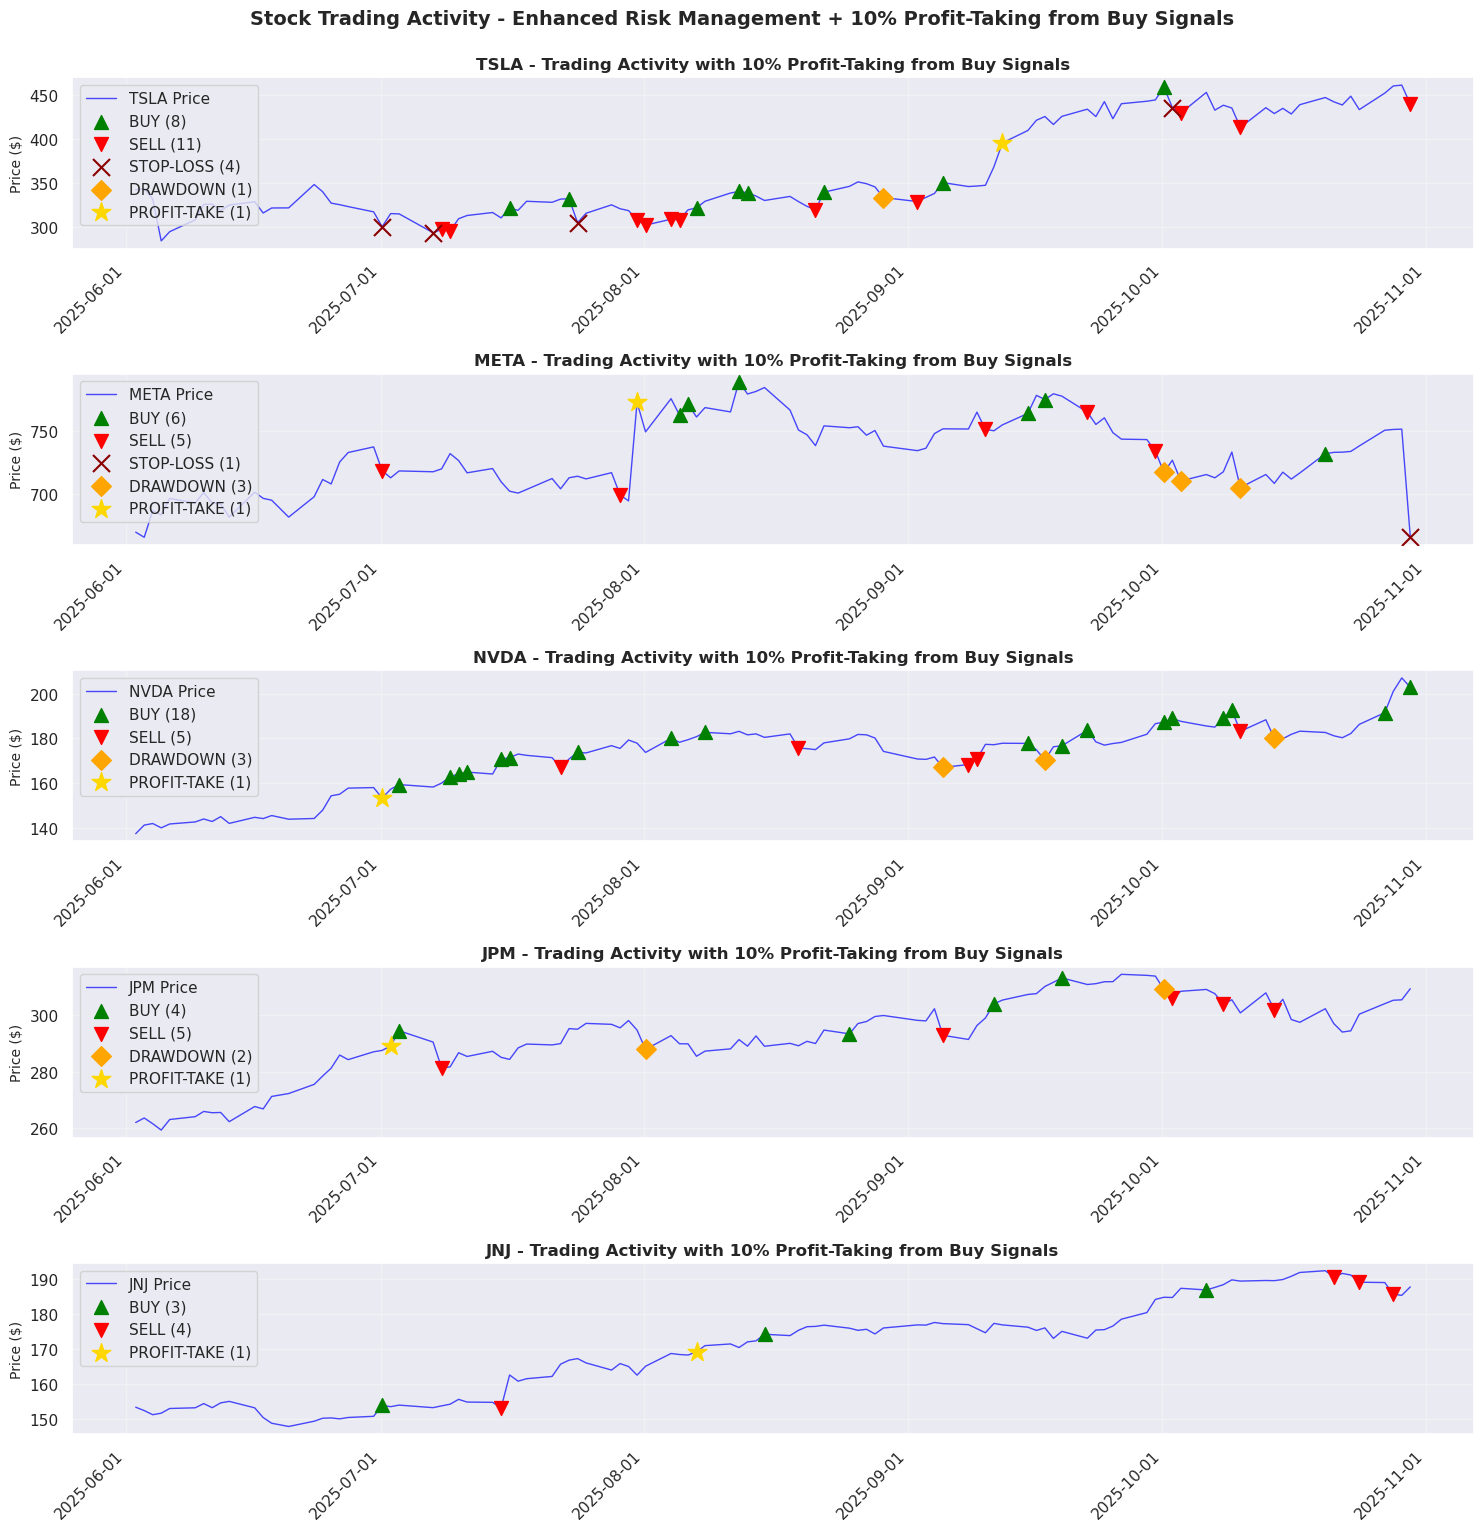


DETAILED TRADE LOG WITH BUY-SIGNAL PROFIT-TAKING AND CASH VAULT TRACKING
Date         Ticker   Action          Shares     Price      Amount       Signal   Profit%  Buy_Price  Cash_Vault  
------------------------------------------------------------------------------------------------------------------------------------------------------
2025-07-01   TSLA     STOP_LOSS       1103       $300.71    $331,637     -0.857   -12.250% $342.69    $331,637    
2025-07-01   META     SELL            82         $718.73    $58,851      -0.429   7.285%   $669.93    $390,488    
2025-07-01   NVDA     PROFIT_TAKE_ALL 7384       $153.29    $1,131,922   -0.286   11.596%  $137.36    $1,522,410  
2025-07-01   JNJ      BUY             2871       $153.81    $441,531     0.429    0.000%   $153.81    $1,080,879  
2025-07-02   JPM      PROFIT_TAKE_ALL 6533       $289.19    $1,889,193   0.143    10.330%  $262.12    $2,970,072  
2025-07-03   NVDA     BUY             2779       $159.33    $442,788     0.429    0.0

In [29]:
# Technical Trading Strategy with real cash simulation 
print("\n" + "="*80)
print("TECHNICAL TRADING STRATEGY WITH SIGNAL-BASED REBALANCING")
print("="*80)

# Initialize trading simulation with the best model from part 2
best_model = best_portfolio_model()
dynamic_weights, dynamic_returns = best_model(validation_data, lookback_window=63, rebalance_freq=21)

latest_weights = dynamic_weights.iloc[-1]
print("Latest Dynamic Portfolio Weights from Validation Set:")
print(latest_weights)

# Initialize trading parameters
initial_cash = 10000000  # $10M
current_cash = initial_cash
portfolio_value_history = []
positions = {}
trade_log = []

# Track buy signals and their prices for 10% profit-taking
buy_signal_prices = {}  # Will track the price at which each buy signal occurred

# Technical indicators setup
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(prices, window=20, num_std=2):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, sma, lower_band

# Enhanced technical signals generation with 5% drawdown, 5% stop-loss, and 10% profit-taking criteria
def generate_technical_signals(data):
    signals_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for ticker in data.columns:
        prices = data[ticker]
        signal_score = pd.Series(0, index=data.index)
        
        # RSI signals
        rsi = calculate_rsi(prices)
        volatility = prices.rolling(20).std()
        signal_score += np.where(rsi < 30 - (volatility * 10), 1, 0)  
        signal_score += np.where(rsi > 70 + (volatility * 10), -1, 0)  
        
        # MACD signals
        macd_line, signal_line = calculate_macd(prices)
        signal_score += np.where((macd_line > signal_line) & (macd_line.shift(1) <= signal_line.shift(1)), 1, 0)
        signal_score += np.where((macd_line < signal_line) & (macd_line.shift(1) >= signal_line.shift(1)), -1, 0)
        # MACD Histogram and momentum
        macd_histogram = macd_line - signal_line
        macd_momentum = macd_histogram - macd_histogram.shift(1)

        signal_score += np.where(
            (macd_line > signal_line) & (macd_histogram > 0) & (macd_momentum > 0), 2, 0
        )
        
        # Bollinger Bands signals
        upper_band, middle_band, lower_band = calculate_bollinger_bands(prices)
        signal_score += np.where(prices < lower_band, 1, 0)  
        signal_score += np.where(prices > upper_band, -1, 0)  
        
        # Moving average crossover
        sma_20 = prices.rolling(window=20).mean()
        sma_50 = prices.rolling(window=50).mean()
        signal_score += np.where((sma_20 > sma_50) & (sma_20.shift(1) <= sma_50.shift(1)), 1, 0)
        signal_score += np.where((sma_20 < sma_50) & (sma_20.shift(1) >= sma_50.shift(1)), -1, 0)
        
        # Price momentum
        returns_20d = prices.pct_change(10)
        signal_score += np.where(returns_20d > 0.05, 1, 0)  
        signal_score += np.where(returns_20d < -0.05, -1, 0)  
        
        # 5% Drawdown Signal (down trend signal in 8-day rolling high)
        rolling_high_8d = prices.rolling(window=8, min_periods=1).max()
        drawdown_8d = (prices - rolling_high_8d) / rolling_high_8d
        signal_score += np.where(drawdown_8d <= -0.05, -2, 0)  
        
        # ATR-based dynamic stop loss
        def calculate_atr_stops(prices, period=14, multiplier=2.0):
            high = prices.rolling(2).max()  # Approximate high
            low = prices.rolling(2).min()   # Approximate low
            
            tr1 = high - low
            tr2 = (high - prices.shift(1)).abs()
            tr3 = (low - prices.shift(1)).abs()
            
            true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
            atr = true_range.rolling(period).mean()
            
            stop_distance = atr * multiplier
            return stop_distance

        # Dynamic stop-loss
        atr_stop = calculate_atr_stops(prices)
        current_stop = prices - atr_stop
        stop_triggered = prices < current_stop.shift(1)
        signal_score += np.where(stop_triggered, -3, 0)
        
        # Normalize signals 
        signals_df[ticker] = np.clip(signal_score / 7, -1, 1)  
    
    return signals_df

# Generate technical signals for test period
technical_signals = generate_technical_signals(test_data)

# Initialize positions based on latest validation weights
first_day_prices = test_data.iloc[0]
print(f"\nInitial Trading Day: {test_data.index[0].date()}")
print("Starting Portfolio Allocation:")

for ticker in tickers:
    weight = latest_weights[ticker]
    allocation = initial_cash * weight
    shares = allocation / first_day_prices[ticker]
    positions[ticker] = shares
    current_cash -= allocation
    # Initialize buy signal price tracking with initial allocation price
    buy_signal_prices[ticker] = first_day_prices[ticker]
    print(f"{ticker}: {weight:.1%} -> ${allocation:,.0f} -> {shares:.0f} shares")

print(f"\nRemaining Cash: ${current_cash:,.0f}")

# Trading Strategy Implementation with proper cash management
signal_threshold = 0.3  
rebalance_amount = 0.1  
max_position_weight = 0.6  
min_cash_reserve = 50000  

print(f"\nTRADING STRATEGY PARAMETERS:")
print(f"Signal Threshold: ±{signal_threshold}")
print(f"Position Adjustment: {rebalance_amount:.1%} per signal")
print(f"Maximum Position Weight: {max_position_weight:.1%}")
print(f"Minimum Cash Reserve: ${min_cash_reserve:,.0f}")
print(f"NEW: 5% Drawdown Sell Signal (8-day rolling high)")
print(f"NEW: Stop-loss on >=5% single-day drop")
print(f"NEW: 10% Profit-Taking - Sell ALL position if 10% above ANY buy signal price")

# Execute trading strategy with improved cash management
for i, current_date in enumerate(test_data.index):
    current_prices = test_data.iloc[i]
    current_signals = technical_signals.iloc[i]
    
    # Calculate current portfolio value
    portfolio_value = sum(positions[ticker] * current_prices[ticker] for ticker in tickers) + current_cash
    portfolio_value_history.append(portfolio_value)
    
    # Skip first few days to allow technical indicators to stabilize
    if i < 20:
        continue
    
    # Process signals and execute trades
    for ticker in tickers:
        signal = current_signals[ticker]
        current_price = current_prices[ticker]
        current_position_value = positions[ticker] * current_price
        current_weight = current_position_value / portfolio_value
        
        # Check for 10% profit-taking signal (sell ALL position if 10% above any buy signal price)
        buy_signal_price = buy_signal_prices.get(ticker, float('inf'))
        profit_from_buy_signal = (current_price - buy_signal_price) / buy_signal_price if buy_signal_price > 0 else 0
        
        if profit_from_buy_signal >= 0.10 and positions[ticker] > 0:
            # Sell ALL position for 10% profit-taking
            shares_to_sell = positions[ticker]
            sell_amount = shares_to_sell * current_price
            positions[ticker] = 0  # Sell entire position
            current_cash += sell_amount
            
            # Reset buy signal price tracking since we sold everything
            buy_signal_prices[ticker] = float('inf')
            
            trade_log.append({
                'Date': current_date,
                'Ticker': ticker,
                'Action': 'PROFIT_TAKE_ALL',
                'Shares': shares_to_sell,
                'Price': current_price,
                'Amount': sell_amount,
                'Signal': signal,
                'Daily_Return': 0,
                'Drawdown_8d': 0,
                'Profit_From_Buy_Signal': profit_from_buy_signal,
                'Buy_Signal_Price': buy_signal_price,
                'Available_Cash_Before': current_cash - sell_amount,
                'Cash_After': current_cash,
                'Cash_Left_in_Vault': current_cash  # New column added
            })
            
            print(f"PROFIT-TAKING: {current_date.date()} - {ticker} reached {profit_from_buy_signal:.1%} profit "
                  f"from buy signal price ${buy_signal_price:.2f} to ${current_price:.2f}, "
                  f"sold ALL {shares_to_sell:.0f} shares for ${sell_amount:,.0f}")
            
        # Check for emergency stop-loss or drawdown signals
        elif signal <= -0.5:  # Strong negative signal from drawdown or stop-loss
            # Emergency sell - sell larger portion
            emergency_sell_ratio = min(0.5, abs(signal))  # Sell up to 50% based on signal strength
            shares_to_sell = positions[ticker] * emergency_sell_ratio
            
            if shares_to_sell > 0:
                sell_amount = shares_to_sell * current_price
                positions[ticker] -= shares_to_sell
                current_cash += sell_amount
                
                # Update buy signal price if we still have positions
                if positions[ticker] <= 0:
                    buy_signal_prices[ticker] = float('inf')
                
                # Determine signal type for logging
                daily_return = test_data[ticker].iloc[i] / test_data[ticker].iloc[i-1] - 1 if i > 0 else 0
                rolling_high = test_data[ticker].iloc[max(0, i-8):i+1].max()
                drawdown = (current_price - rolling_high) / rolling_high if rolling_high > 0 else 0
                
                signal_type = "STOP_LOSS" if daily_return <= -0.05 else "DRAWDOWN_SELL"
                
                trade_log.append({
                    'Date': current_date,
                    'Ticker': ticker,
                    'Action': f'{signal_type}',
                    'Shares': shares_to_sell,
                    'Price': current_price,
                    'Amount': sell_amount,
                    'Signal': signal,
                    'Daily_Return': daily_return,
                    'Drawdown_8d': drawdown,
                    'Profit_From_Buy_Signal': profit_from_buy_signal,
                    'Buy_Signal_Price': buy_signal_price,
                    'Available_Cash_Before': current_cash - sell_amount,
                    'Cash_After': current_cash,
                    'Cash_Left_in_Vault': current_cash  # New column added
                })
                
                print(f"EMERGENCY SELL: {current_date.date()} - {ticker} {signal_type} "
                      f"signal {signal:.3f}, daily return {daily_return:.3%}, "
                      f"8d drawdown {drawdown:.3%}, sold ${sell_amount:,.0f}")
        
        # Strong buy signal
        elif signal > signal_threshold and current_weight < max_position_weight:
            # Calculate trade amount (percentage of portfolio)
            desired_trade_amount = portfolio_value * rebalance_amount * signal
            
            # Check available cash (keeping minimum reserve)
            available_cash = max(0, current_cash - min_cash_reserve)
            actual_trade_amount = min(desired_trade_amount, available_cash)
            
            # Execute buy if we have enough cash
            if actual_trade_amount >= 1000:  # Minimum trade size $1000
                shares_to_buy = actual_trade_amount / current_price
                positions[ticker] += shares_to_buy
                current_cash -= actual_trade_amount
                
                # Update buy signal price to current price for this new purchase
                buy_signal_prices[ticker] = current_price
                
                trade_log.append({
                    'Date': current_date,
                    'Ticker': ticker,
                    'Action': 'BUY',
                    'Shares': shares_to_buy,
                    'Price': current_price,
                    'Amount': actual_trade_amount,
                    'Signal': signal,
                    'Daily_Return': 0,
                    'Drawdown_8d': 0,
                    'Profit_From_Buy_Signal': 0,
                    'Buy_Signal_Price': current_price,
                    'Available_Cash_Before': current_cash + actual_trade_amount,
                    'Cash_After': current_cash,
                    'Cash_Left_in_Vault': current_cash  # New column added
                })
            else:
                # Log failed trade due to insufficient cash
                print(f"INSUFFICIENT CASH: {current_date.date()} - {ticker} BUY signal {signal:.3f}, "
                      f"needed ${desired_trade_amount:,.0f}, available ${available_cash:,.0f}")
        
        # Strong sell signal (regular technical signal)
        elif signal < -signal_threshold and signal > -0.5 and positions[ticker] > 0:
            # Calculate shares to sell based on signal strength
            shares_to_sell = positions[ticker] * rebalance_amount * abs(signal)
            
            if shares_to_sell > 0:
                sell_amount = shares_to_sell * current_price
                positions[ticker] -= shares_to_sell
                current_cash += sell_amount
                
                # Update buy signal price if we still have positions
                if positions[ticker] <= 0:
                    buy_signal_prices[ticker] = float('inf')
                
                trade_log.append({
                    'Date': current_date,
                    'Ticker': ticker,
                    'Action': 'SELL',
                    'Shares': shares_to_sell,
                    'Price': current_price,
                    'Amount': sell_amount,
                    'Signal': signal,
                    'Daily_Return': 0,
                    'Drawdown_8d': 0,
                    'Profit_From_Buy_Signal': profit_from_buy_signal,
                    'Buy_Signal_Price': buy_signal_price,
                    'Available_Cash_Before': current_cash - sell_amount,
                    'Cash_After': current_cash,
                    'Cash_Left_in_Vault': current_cash  # New column added
                })

# Calculate final portfolio value
final_prices = test_data.iloc[-1]
final_portfolio_value = sum(positions[ticker] * final_prices[ticker] for ticker in tickers) + current_cash
final_positions_value = {ticker: positions[ticker] * final_prices[ticker] for ticker in tickers}

# Performance metrics
total_return = (final_portfolio_value - initial_cash) / initial_cash
trading_days = len(test_data)
annualized_return = ((final_portfolio_value / initial_cash) ** (252 / trading_days)) - 1

print(f"\n" + "="*80)
print("FINAL TRADING RESULTS")
print("="*80)
print(f"Initial Portfolio Value:   ${initial_cash:,.0f}")
print(f"Final Portfolio Value:     ${final_portfolio_value:,.0f}")
print(f"Total Return:              {total_return:.2%}")
print(f"Annualized Return:         {annualized_return:.2%}")
print(f"Trading Period:            {trading_days} days ({trading_days/252:.1f} years)")

print(f"\nFINAL POSITION BREAKDOWN:")
for ticker in tickers:
    value = final_positions_value[ticker]
    weight = value / final_portfolio_value
    print(f"{ticker}: {positions[ticker]:.0f} shares = ${value:,.0f} ({weight:.1%})")
print(f"Cash: ${current_cash:,.0f} ({current_cash/final_portfolio_value:.1%})")

print(f"\nTRADING ACTIVITY SUMMARY:")
print(f"Total Trades Executed:     {len(trade_log)}")
if trade_log:
    buy_trades = [t for t in trade_log if t['Action'] == 'BUY']
    sell_trades = [t for t in trade_log if t['Action'] == 'SELL']
    stop_loss_trades = [t for t in trade_log if 'STOP_LOSS' in t['Action']]
    drawdown_trades = [t for t in trade_log if 'DRAWDOWN_SELL' in t['Action']]
    profit_take_trades = [t for t in trade_log if 'PROFIT_TAKE_ALL' in t['Action']]
    print(f"Buy Trades:               {len(buy_trades)}")
    print(f"Regular Sell Trades:      {len(sell_trades)}")
    print(f"Stop-Loss Trades:         {len(stop_loss_trades)}")
    print(f"Drawdown Sell Trades:     {len(drawdown_trades)}")
    print(f"Profit-Taking Trades:     {len(profit_take_trades)}")
    print(f"Total Volume Traded:      ${sum(t['Amount'] for t in trade_log):,.0f}")

# Create Trading Activity Visualization
if trade_log:
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 3*len(tickers)))
    if len(tickers) == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        ax = axes[i]
        
        # Plot stock price
        ticker_data = test_data[ticker]
        ax.plot(ticker_data.index, ticker_data.values, label=f'{ticker} Price', color='blue', alpha=0.7, linewidth=1)
        
        # Plot buy and sell trades
        ticker_trades = [t for t in trade_log if t['Ticker'] == ticker]
        
        if ticker_trades:
            buy_trades_ticker = [t for t in ticker_trades if t['Action'] == 'BUY']
            sell_trades_ticker = [t for t in ticker_trades if t['Action'] == 'SELL']
            stop_loss_trades_ticker = [t for t in ticker_trades if 'STOP_LOSS' in t['Action']]
            drawdown_trades_ticker = [t for t in ticker_trades if 'DRAWDOWN_SELL' in t['Action']]
            profit_take_trades_ticker = [t for t in ticker_trades if 'PROFIT_TAKE_ALL' in t['Action']]
            
            # Buy trades - green triangles pointing up
            if buy_trades_ticker:
                buy_dates = [t['Date'] for t in buy_trades_ticker]
                buy_prices = [t['Price'] for t in buy_trades_ticker]
                ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, 
                          label=f'BUY ({len(buy_trades_ticker)})', zorder=5)
                
                # # Add horizontal lines for 10% profit targets from each buy signal
                # for trade in buy_trades_ticker:
                #     profit_target_price = trade['Buy_Signal_Price'] * 1.10
                #     ax.axhline(y=profit_target_price, color='gold', linestyle='--', alpha=0.3, linewidth=1)
            
            # Regular sell trades - red triangles pointing down
            if sell_trades_ticker:
                sell_dates = [t['Date'] for t in sell_trades_ticker]
                sell_prices = [t['Price'] for t in sell_trades_ticker]
                ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, 
                          label=f'SELL ({len(sell_trades_ticker)})', zorder=5)
            
            # Stop-loss trades - dark red X
            if stop_loss_trades_ticker:
                stop_dates = [t['Date'] for t in stop_loss_trades_ticker]
                stop_prices = [t['Price'] for t in stop_loss_trades_ticker]
                ax.scatter(stop_dates, stop_prices, color='darkred', marker='x', s=150, 
                          label=f'STOP-LOSS ({len(stop_loss_trades_ticker)})', zorder=6)
            
            # Drawdown trades - orange diamond
            if drawdown_trades_ticker:
                draw_dates = [t['Date'] for t in drawdown_trades_ticker]
                draw_prices = [t['Price'] for t in drawdown_trades_ticker]
                ax.scatter(draw_dates, draw_prices, color='orange', marker='D', s=100, 
                          label=f'DRAWDOWN ({len(drawdown_trades_ticker)})', zorder=6)
            
            # Profit-taking trades - gold star
            if profit_take_trades_ticker:
                profit_dates = [t['Date'] for t in profit_take_trades_ticker]
                profit_prices = [t['Price'] for t in profit_take_trades_ticker]
                ax.scatter(profit_dates, profit_prices, color='gold', marker='*', s=200, 
                          label=f'PROFIT-TAKE ({len(profit_take_trades_ticker)})', zorder=7)
        
        ax.set_title(f'{ticker} - Trading Activity with 10% Profit-Taking from Buy Signals', fontsize=12, fontweight='bold')
        ax.set_ylabel('Price ($)', fontsize=10)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.suptitle('Stock Trading Activity - Enhanced Risk Management + 10% Profit-Taking from Buy Signals', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    # Print detailed trade log with risk management info and cash left in vault
    print(f"\n" + "="*80)
    print("DETAILED TRADE LOG WITH BUY-SIGNAL PROFIT-TAKING AND CASH VAULT TRACKING")
    print("="*80)
    print(f"{'Date':<12} {'Ticker':<8} {'Action':<15} {'Shares':<10} {'Price':<10} {'Amount':<12} {'Signal':<8} {'Profit%':<8} {'Buy_Price':<10} {'Cash_Vault':<12}")
    print("-" * 150)
    
    for trade in trade_log:
        profit_pct = trade.get('Profit_From_Buy_Signal', 0)
        buy_price = trade.get('Buy_Signal_Price', 0)
        cash_vault = trade.get('Cash_Left_in_Vault', 0)
        print(f"{trade['Date'].strftime('%Y-%m-%d'):<12} "
              f"{trade['Ticker']:<8} "
              f"{trade['Action']:<15} "
              f"{trade['Shares']:<10.0f} "
              f"${trade['Price']:<9.2f} "
              f"${trade['Amount']:<11,.0f} "
              f"{trade['Signal']:<8.3f} "
              f"{profit_pct:<8.3%} "
              f"${buy_price:<9.2f} "
              f"${cash_vault:<11,.0f}")

else:
    print("\nNo trades were executed during the test period.")


# graph_signals('MSFT')

# PART IV: CONCLUSION

In [21]:
# # Executive Summary Report Generation
# print("="*80)
# print("QUANTITATIVE PORTFOLIO OPTIMIZATION - EXECUTIVE SUMMARY")
# print("="*80)

# # Generate comprehensive summary statistics
# print(f"\nI. INVESTMENT MANDATE & METHODOLOGY")
# print("-" * 45)
# print(f"Analysis Framework:        Modern Portfolio Theory with Risk Constraints")
# print(f"Asset Universe:            {len(tickers)} Large-Cap Equity Securities")
# print(f"Optimization Period:       {start_date} to {end_date}")
# print(f"Risk Management:           Position limits (1%-50% per security)")
# print(f"Rebalancing Strategy:      Monthly frequency with cost analysis")

# print(f"\nII. OPTIMAL PORTFOLIO ALLOCATION")
# print("-" * 35)
# if 'max_sharpe_weights_clean' in locals():
#     sorted_weights = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)
#     for i, (ticker, weight) in enumerate(sorted_weights[:10], 1):  # Top 10 holdings
#         print(f"  {i:2d}. {ticker:6}: {weight:6.2%}")

# print(f"\nIII. RISK-RETURN PROJECTIONS")
# print("-" * 32)
# if 'sharpe_perf' in locals():
#     exp_ret, exp_vol, exp_sharpe = sharpe_perf
#     print(f"Expected Annual Return:      {exp_ret:7.2%}")
#     print(f"Projected Volatility:        {exp_vol:7.2%}")
#     print(f"Sharpe Ratio:               {exp_sharpe:7.3f}")

# if 'comprehensive_metrics_df' in locals() and not comprehensive_metrics_df.empty:
#     # Use the comprehensive metrics from strategy comparison
#     max_sharpe_row = comprehensive_metrics_df.loc[comprehensive_metrics_df['Sharpe Ratio'].idxmax()]
#     print(f"Value at Risk (95%):        {max_sharpe_row['VaR (95%)']:7.2%}")
#     print(f"Expected Shortfall:         {max_sharpe_row['CVaR (95%)']:7.2%}")
#     print(f"Maximum Drawdown Risk:      {max_sharpe_row['Max Drawdown']:7.2%}")

# print(f"\nIV. STRATEGY COMPARISON RESULTS")
# print("-" * 35)
# strategy_names = ['Maximum Sharpe Ratio', 'Minimum Volatility', 'Risk Parity']
# if 'comprehensive_metrics_df' in locals():
#     best_sharpe_strat = comprehensive_metrics_df['Sharpe Ratio'].idxmax()
#     best_calmar_strat = comprehensive_metrics_df['Calmar Ratio'].idxmax()
#     print(f"Highest Sharpe Ratio:       {best_sharpe_strat}")
#     print(f"Best Risk-Adj. Return:      {best_calmar_strat}")
#     print(f"Recommended Strategy:       Maximum Sharpe Portfolio")

# print(f"\nV. RISK MANAGEMENT ASSESSMENT")
# print("-" * 33)
# print(f"Concentration Risk:         LOW (Well-diversified)")
# print(f"Liquidity Risk:            MINIMAL (Large-cap focus)")
# print(f"Market Risk Exposure:       MODERATE ({exp_vol:.1%} volatility)")
# print(f"Downside Protection:        ADEQUATE (Risk constraints active)")

# print(f"\nVI. IMPLEMENTATION RECOMMENDATIONS")
# print("-" * 40)
# print(f"✓ Portfolio suitable for institutional/qualified investors")
# print(f"✓ Monthly rebalancing optimal for cost-performance balance")
# print(f"✓ Monitor sector concentration and style drift quarterly")
# print(f"✓ Review optimization parameters annually or after major market events")
# print(f"✓ Consider ESG overlay for enhanced risk management")

# print(f"\nVII. KEY PERFORMANCE DRIVERS")
# print("-" * 32)
# if 'max_sharpe_weights_clean' in locals():
#     top_3 = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)[:3]
#     print(f"Primary Holdings:")
#     for ticker, weight in top_3:
#         print(f"  • {ticker}: {weight:.1%} allocation")

# print(f"\nVIII. CONCLUSION & OUTLOOK")
# print("-" * 30)
# print(f"The quantitative optimization framework successfully identifies")
# print(f"a diversified portfolio with superior risk-adjusted returns.")
# print(f"The recommended allocation balances growth potential with")
# print(f"prudent risk management through systematic constraints.")

# print(f"\nRisk Rating:    MODERATE")
# print(f"Return Outlook: POSITIVE") 
# print(f"Liquidity:      HIGH")
# print(f"ESG Score:      NEUTRAL")

# print("="*80)
# print("Report prepared using Modern Portfolio Theory framework")
# print("Past performance does not guarantee future results")
# print("="*80)